In [1]:
import sys
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import torch

torch.manual_seed(42)

sns.set_theme(style="white")

--- 

# Putting Together a Base Dataset

In this notebook we are going to create a base table on which to train a first simple model on. This dataset will contain 
- __Cell-line features__ like Gene Expression and Copy-Number-Variation information as one input and 
- __Drug Features__ as the de-Morgan fingerprints for specific drugs as another input. 

These features got created in the following notebooks:  
- `02_GDSC_map_GenExpr.ipynb`
- `03_GDSC_map_CNV.ipynb`
- `05_DrugFeatures.ipynb`

In [2]:
!pwd
!find ../../datasets/gdsc/my_datasets -ls

/Users/cwoest/Documents/Academics/Data_Science_UP/master_thesis/material/GNN-material
37700889        0 drwxr-xr-x    8 cwoest           staff                 256 May  9 16:27 ../../datasets/gdsc/my_datasets
37938781    96424 -rw-r--r--    1 cwoest           staff            49365274 May  9 15:54 ../../datasets/gdsc/my_datasets/gdsc_base.pkl
37704542  7461488 -rw-r--r--    1 cwoest           staff            3820277941 May  5 14:52 ../../datasets/gdsc/my_datasets/joined_gdsc_cnv_gistic.pkl
37701975  6435440 -rw-r--r--    1 cwoest           staff            3292923584 May  9 10:59 ../../datasets/gdsc/my_datasets/joined_gdsc_geneexpr.pkl
37867797    14480 -rw-r--r--    1 cwoest           staff             7413076 May  9 11:31 ../../datasets/gdsc/my_datasets/geneexpr_sparse.pkl
37940951     1504 -rw-r--r--    1 cwoest           staff              769884 May  9 16:27 ../../datasets/gdsc/my_datasets/drug_name_fingerprints.pkl
37700990  7681336 -rw-r--r--    1 cwoest           staff         

In [3]:
PATH_TO_SAVE_DATA_TO = '../../datasets/gdsc/my_datasets/'

# GDSC base table.
GDSC_BASE_FILE = 'gdsc_base.pkl'

# Cell-line feature
CNV_GISTIC_FILE = 'joined_gdsc_cnv_gistic.pkl'
CNV_PICNIC_FILE = 'joined_gdsc_cnv_picnic.pkl'
GENE_EXPR_FILE = 'joined_gdsc_geneexpr.pkl'

# Drug features
FINGERPRINTS_FILE = 'drug_name_fingerprints.pkl'

---

## Download

Download data created by the previous notebooks.

In [4]:
start = time.time()
gdsc_base = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}{GDSC_BASE_FILE}')
print(f"File `{GDSC_BASE_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {gdsc_base.shape}")

File `gdsc_base.pkl` took 0.07293 seconds to import. 
Shape: (446521, 14)


In [5]:
start = time.time()
cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}{CNV_GISTIC_FILE}')
print(f"File `{CNV_GISTIC_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_gistic.shape}")

File `joined_gdsc_cnv_gistic.pkl` took 73.98715 seconds to import. 
Shape: (446521, 952)


In [6]:
start = time.time()
cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}{CNV_PICNIC_FILE}')
print(f"File `{CNV_PICNIC_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {cnv_picnic.shape}")

File `joined_gdsc_cnv_picnic.pkl` took 80.10469 seconds to import. 
Shape: (446521, 980)


In [7]:
start = time.time()
gene_expr = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}{GENE_EXPR_FILE}')
print(f"File `{GENE_EXPR_FILE}` took {time.time()-start:.5f} seconds to import. \nShape: {gene_expr.shape}")

File `joined_gdsc_geneexpr.pkl` took 4.24449 seconds to import. 
Shape: (446521, 922)


In [8]:
start = time.time()
fingerprints = pd.read_pickle(f'{PATH_TO_SAVE_DATA_TO}{FINGERPRINTS_FILE}')
print(f"File `{FINGERPRINTS_FILE}` took {time.time()-start:.5f} seconds to import. \nLength: {len(fingerprints)}")

File `drug_name_fingerprints.pkl` took 0.05682 seconds to import. 
Length: 449


In [9]:
print(f"""
    GDSC base    : {gdsc_base.shape}
    CNV Gistic   : {cnv_gistic.shape}
    CNV Picnic   : {cnv_picnic.shape}
    Gene Expr    : {gene_expr.shape}
    Fingerprints : {len(fingerprints)}
""")


    GDSC base    : (446521, 14)
    CNV Gistic   : (446521, 952)
    CNV Picnic   : (446521, 980)
    Gene Expr    : (446521, 922)
    Fingerprints : 449



---

# Simple Model - Gene Expression Only

First, we try to create a simple Neural Network using the gene expression information only. Meaning, we will only use table `gene_expr`. 

In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [11]:
gene_expr.head(3)

,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [12]:
gene_expr_base = gene_expr.loc[:, ~gene_expr.columns.isin(
    ['DRUG_ID', 
    'CELL_LINE_NAME',
    'CELL_ID',
    'MASTER_CELL_ID',
    'DATASET',
    'Z_SCORE',
    'DRUG_NAME',
    'RMSE',
    'AUC',
    'COSMIC_ID',
    'POSITION'])
]
gene_expr_base.head(3)

,LN_IC50,CONC,INTENSITY,TSPAN6,SCYL3,BAD,LAP3,SNX11,CASP10,CFLAR,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,2.395685,2.0,544404,3.238273,4.856061,5.900525,8.120975,6.789716,3.593983,6.747933,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,3.140923,2.0,404197,8.690198,4.572198,6.927127,5.595564,5.040800,2.776345,4.813174,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,3.968757,2.0,797378,8.233101,4.749715,7.123143,5.458094,4.598347,2.900356,5.130654,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [13]:
v = gene_expr.loc[:, gene_expr.columns!='LN_IC50'].values

KeyboardInterrupt: 

In [13]:
v = gene_expr.loc[:, ~gene_expr.columns.isin(['LN_IC50'])]


In [14]:
'LN_IC50' in gene_expr.columns

True

In [15]:
t = gene_expr['LN_IC50'].values

In [105]:
gene_expr_base.isna().sum().sum()

20435448

In [108]:
gene_expr_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446521 entries, 0 to 5707264
Columns: 911 entries, LN_IC50 to POLG2
dtypes: float64(910), int64(1)
memory usage: 3.0 GB


In [111]:
gene_expr_base.shape

(446521, 911)

In [110]:
gene_nonnan = gene_expr_base.dropna()
gene_nonnan.shape

(424015, 911)

In [202]:
gene_expr_base.iloc[:, 1:].values

array([[2.00000000e+00, 5.44404000e+05, 3.23827251e+00, ...,
        3.01023733e+00, 8.75084800e+00, 6.19936581e+00],
       [2.00000000e+00, 4.04197000e+05, 8.69019791e+00, ...,
        4.79462383e+00, 3.58852758e+00, 6.78520131e+00],
       [2.00000000e+00, 7.97378000e+05, 8.23310113e+00, ...,
        4.11409177e+00, 5.76809818e+00, 7.50515490e+00],
       ...,
       [1.00000000e+01, 1.59580000e+04, 8.59362481e+00, ...,
        3.34734214e+00, 7.21468659e+00, 6.58715604e+00],
       [1.00000000e+01, 2.54190000e+04, 8.44162845e+00, ...,
        3.44324413e+00, 8.34896465e+00, 6.33635721e+00],
       [1.00000000e+01, 1.34730000e+04, 6.98164324e+00, ...,
        4.30818433e+00, 2.91918023e+00, 6.40410310e+00]])

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# Hyper-parameters 
input_size = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                 # One value per feature
hidden_size = 100
num_classes = 1
num_epochs = 2
batch_size = 10_000
learning_rate = 0.001

In [47]:
# Create pytorch Dataset out of the gene expression dataframe.
from torch.utils.data import Dataset

class GeneExpressionDataset(Dataset):
    """Customized class for Gene Expression data preparation."""

    def __init__(self, pd_geneexpr_dataframe: pd.DataFrame, target_name: str = 'LN_IC50'):
        """Initializes the dataset object."""
        gene_expr_df = pd_geneexpr_dataframe
        assert target_name in gene_expr_df.columns

        X = gene_expr_df.loc[:, ~gene_expr_df.columns.isin([target_name])].values
        y = gene_expr_df[target_name].values

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.y)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the given index `idx`."""
        return self.X[idx], self.y[idx]

In [17]:
gene_expr_dataset = GeneExpressionDataset(pd_geneexpr_dataframe=gene_expr_base,
                                          target_name='LN_IC50')

In [23]:
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(gene_expr_dataset))
test_size = len(gene_expr_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(gene_expr_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

In [29]:
print(f"""
    Shapes 
        Train : 
            X : {train_set.dataset.X.shape}
            y : {train_set.dataset.y.shape}
        Test  :
            X : {test_set.dataset.X.shape}
            y : {test_set.dataset.y.shape}
""")


    Shapes 
        Train : 
            X : torch.Size([446521, 910])
            y : torch.Size([446521])
        Test  :
            X : torch.Size([446521, 910])
            y : torch.Size([446521])



In [43]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=0)       

In [53]:
for i, (X, y) in enumerate(train_loader): 
    if i == 1: break
    print(f"""
    i = {i}
        X = {X}
        y = {y}
        X.size : {X.size()}
        y.size : {y.size()}
    """)


    i = 0
        X = tensor([[1.0240e+01, 8.7761e+05, 7.8985e+00,  ..., 4.1138e+00, 3.1903e+00,
         5.4369e+00],
        [2.0000e+01, 4.3556e+05, 3.3886e+00,  ..., 4.6263e+00, 6.8246e+00,
         6.4895e+00],
        [1.0000e+01, 4.3293e+04, 8.2143e+00,  ..., 4.1281e+00, 6.0327e+00,
         7.5018e+00],
        ...,
        [5.0000e+01, 2.3497e+07, 3.1896e+00,  ..., 3.8713e+00, 9.2537e+00,
         5.6479e+00],
        [2.0000e+00, 2.4176e+04, 3.6547e+00,  ..., 4.6862e+00, 5.5265e+00,
         5.0838e+00],
        [1.0000e+01, 9.5980e+03, 8.8486e+00,  ..., 3.4825e+00, 7.0952e+00,
         5.9602e+00]])
        y = tensor([5.7684, 3.7713, 6.1509,  ..., 0.9570, 3.1641, 1.3138])
        X.size : torch.Size([10000, 910])
        y.size : torch.Size([10000])
    


In [54]:
count = 0
for i, (X, y) in enumerate(train_loader): 
    count += 1
print(f"train count : {count}") 

count = 0
for i, (X, y) in enumerate(test_loader): 
    count += 1
print(f"test count  : {count}") 

train count : 36
test count  : 9


In [59]:
# Hyper-parameters 
input_size = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                 # One value per feature
hidden_size = 100
num_classes = 1
num_epochs = 2
batch_size = 10_000
learning_rate = 0.001

In [94]:
# Fully connected neural network with one hidden layer
class SimpleNN_GeneExpr(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN_GeneExpr, self).__init__()
        print(f"""
            input_size  = {input_size}
            hidden_size = {hidden_size}
            num_classes = {num_classes}
        """)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [95]:
model = SimpleNN_GeneExpr(input_size, hidden_size, num_classes).to(device)
print(model)


            input_size  = 910
            hidden_size = 100
            num_classes = 1
        
SimpleNN_GeneExpr(
  (fc1): Linear(in_features=910, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


In [85]:
# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [65]:
# Train the model
total_step = len(train_loader)
it = iter(train_loader)
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):  
        #images = images.reshape(-1, 28*28).to(device)
        #labels = labels.to(device)

        # Move tensors to the configured device
        X = X_batch.to(device)  # All feature values
        y = y_batch.to(device)  # The ln(IC50) values
        
        # Forward pass
        outputs = model(X_batch)
        print(outputs)
        if i == 0: break
        loss = loss_func(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0: # was % 100 before
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2], Step [5/36], Loss: nan
Epoch [1/2], Step [10/36], Loss: nan
Epoch [1/2], Step [15/36], Loss: nan
Epoch [1/2], Step [20/36], Loss: nan
Epoch [1/2], Step [25/36], Loss: nan
Epoch [1/2], Step [30/36], Loss: nan
Epoch [1/2], Step [35/36], Loss: nan


/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([7216])) that is different to the input size (torch.Size([7216, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/2], Step [5/36], Loss: nan
Epoch [2/2], Step [10/36], Loss: nan
Epoch [2/2], Step [15/36], Loss: nan
Epoch [2/2], Step [20/36], Loss: nan
Epoch [2/2], Step [25/36], Loss: nan
Epoch [2/2], Step [30/36], Loss: nan
Epoch [2/2], Step [35/36], Loss: nan


In [156]:

# ---------------------------------
# Define Hyperparameterspace
# --------------------------------- 
input_size = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                 # One value per feature
hidden_size = 100
num_classes = 1
num_epochs = 10
batch_size = 20_000
learning_rate = 0.001

# ---------------------------------
# Create the Dataset
# ---------------------------------
gene_expr_dataset = GeneExpressionDataset(pd_geneexpr_dataframe=gene_nonnan,
                                          target_name='LN_IC50')

train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(gene_expr_dataset))
test_size = len(gene_expr_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(gene_expr_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=0)    

In [157]:
# ---------------------------------
# Build the Neural Netowrk
# ---------------------------------

# Fully connected neural network with one hidden layer
class SimpleNN_GeneExpr(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN_GeneExpr, self).__init__()
        print(f"""
            input_size  = {input_size}
            hidden_size = {hidden_size}
            num_classes = {num_classes}
        """)
        self.fc1 = nn.Linear(input_size, hidden_size)   # module that applies a linear transformation on the input using its stored weights and biases.
        self.relu = nn.ReLU()                           # Non-linear activations are what create the complex mappings between the model’s inputs and outputs. No introduce nonlinearity, helping neural networks learn a wide variety of phenomena.
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model
model = SimpleNN_GeneExpr(input_size, hidden_size=64, num_classes=num_classes).to(device)
print(model)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
print(100*"-")

# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# ---------------------------------
# Train the model
# ---------------------------------
loss_values = []
total_step = len(train_loader)
it = iter(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):  
        #images = images.reshape(-1, 28*28).to(device)
        #labels = labels.to(device)
        # if i > 3: break

        # Move tensors to the configured device
        X = X_batch.to(device)  # All feature values
        y = y_batch.to(device)  # The ln(IC50) values
        # print(20*"+")
        # print(f"i={i}")
        # print(X.size())
        # print(y.size())
        # print(X)
        # print(y)
        assert not torch.isnan(X).any(), "X has NaN in it"
        assert not torch.isnan(X).any(), "y has NaN in it"
        # print("outputs...")
        
        # Forward pass
        outputs = model(X_batch)
        loss = loss_func(outputs, y_batch)

        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0: # was % 100 before
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))    

    loss_values.append(running_loss / len(gene_expr_dataset))                              


            input_size  = 910
            hidden_size = 64
            num_classes = 1
        
SimpleNN_GeneExpr(
  (fc1): Linear(in_features=910, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Model structure: SimpleNN_GeneExpr(
  (fc1): Linear(in_features=910, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Layer: fc1.weight | Size: torch.Size([64, 910]) | Values : tensor([[-0.0269, -0.0289,  0.0310,  ...,  0.0093, -0.0131, -0.0231],
        [-0.0095, -0.0036,  0.0024,  ..., -0.0028,  0.0158,  0.0255]],
       grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([64]) | Values : tensor([-0.0276, -0.0186], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([1, 64]) | Values : tensor([[-0.0814,  0.0776, -0.0997, -0.0004, -0.1216,  0.1208,  0.1022, -0.0368,
         -0.0604, -0.0807, -0.0704,  0.0839,  0.0568,  0.0574,  0.0327,  0.0534,
       

/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Step [5/17], Loss: 1679014272.0000
Epoch [1/10], Step [10/17], Loss: 1081321856.0000
Epoch [1/10], Step [15/17], Loss: 593561472.0000


/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([19212])) that is different to the input size (torch.Size([19212, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/10], Step [5/17], Loss: 333701728.0000
Epoch [2/10], Step [10/17], Loss: 161830144.0000
Epoch [2/10], Step [15/17], Loss: 38565292.0000
Epoch [3/10], Step [5/17], Loss: 54327852.0000
Epoch [3/10], Step [10/17], Loss: 21425388.0000
Epoch [3/10], Step [15/17], Loss: 6576365.5000
Epoch [4/10], Step [5/17], Loss: 10743684.0000
Epoch [4/10], Step [10/17], Loss: 6531094.5000
Epoch [4/10], Step [15/17], Loss: 3904108.5000
Epoch [5/10], Step [5/17], Loss: 313738.0938
Epoch [5/10], Step [10/17], Loss: 142707.8750
Epoch [5/10], Step [15/17], Loss: 31234.7090
Epoch [6/10], Step [5/17], Loss: 342373.9375
Epoch [6/10], Step [10/17], Loss: 200063.3906
Epoch [6/10], Step [15/17], Loss: 95424.7031
Epoch [7/10], Step [5/17], Loss: 22191.3223
Epoch [7/10], Step [10/17], Loss: 30197.8672
Epoch [7/10], Step [15/17], Loss: 21614.7305
Epoch [8/10], Step [5/17], Loss: 2963.5806
Epoch [8/10], Step [10/17], Loss: 5392.8320
Epoch [8/10], Step [15/17], Loss: 3439.2063
Epoch [9/10], Step [5/17], Loss: 11

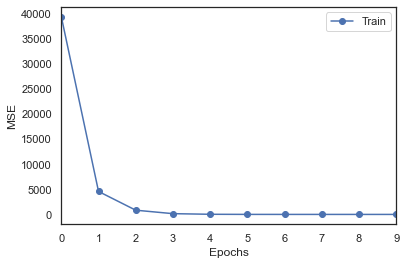

In [187]:
plt.plot(loss_values, linestyle='-', marker='o', label='Train');
plt.xlim(0, 9, 1);
plt.xlabel("Epochs");
plt.ylabel("MSE");
plt.legend();


In [189]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[-0.0269, -0.0289,  0.0310,  ...,  0.0093, -0.0131, -0.0231],
        [-0.0155, -0.0096, -0.0036,  ..., -0.0088,  0.0098,  0.0195],
        [ 0.0061, -0.0083,  0.0073,  ..., -0.0298,  0.0049,  0.0245],
        ...,
        [-0.0231,  0.0236,  0.0253,  ..., -0.0141,  0.0007, -0.0226],
        [-0.0111, -0.0113,  0.0097,  ..., -0.0209, -0.0089,  0.0112],
        [-0.0198,  0.0234,  0.0064,  ..., -0.0039, -0.0163,  0.0033]])
fc1.bias tensor([-0.0276, -0.0246, -0.0266, -0.0269, -0.0033, -0.0299, -0.0013, -0.0185,
         0.0138, -0.0015,  0.0075, -0.0261, -0.0012, -0.0195,  0.0197,  0.0119,
        -0.0245,  0.0285,  0.0317,  0.0275, -0.0239, -0.0060, -0.0016,  0.0263,
         0.0138, -0.0275,  0.0059, -0.0246, -0.0264, -0.0240,  0.0010,  0.0252,
        -0.0282, -0.0232, -0.0184,  0.0026, -0.0216, -0.0088,  0.0056, -0.0270,
        -0.0378,  0.0226,  0.0226,  0.0072,  0.0023, -0.0321,  0.0131, -0.0111,
        -0.0102, -0.0136, -0.0045,  0.0121, -0.0047, -0.0238,  0.0

In [196]:
len(test_loader.dataset.dataset.y)

424015

In [203]:
for i, (X_test_batch, y_test_batch) in enumerate(test_loader):  
    print(X_test_batch.size())
    print(X_test_batch[i])
    print(y_test_batch.size())

torch.Size([20000, 910])
tensor([5.0000e+00, 1.6405e+05, 7.7230e+00, 3.8891e+00, 7.0276e+00, 7.1788e+00,
        4.5978e+00, 2.9991e+00, 5.7122e+00, 7.3056e+00, 5.0119e+00, 5.5608e+00,
        5.0372e+00, 5.9888e+00, 8.3537e+00, 8.2142e+00, 3.4273e+00, 3.1605e+00,
        6.7381e+00, 7.3724e+00, 7.4720e+00, 7.4916e+00, 6.9882e+00, 3.4057e+00,
        8.5154e+00, 3.5651e+00, 4.2408e+00, 8.2399e+00, 6.6031e+00, 2.6824e+00,
        3.8723e+00, 6.0092e+00, 4.2084e+00, 6.1314e+00, 7.8983e+00, 9.1007e+00,
        3.8978e+00, 4.6455e+00, 8.1857e+00, 6.1570e+00, 7.6178e+00, 6.9075e+00,
        8.0815e+00, 7.8934e+00, 9.4280e+00, 7.3091e+00, 4.6702e+00, 1.0381e+01,
        8.1890e+00, 8.1509e+00, 9.9711e+00, 6.3114e+00, 6.4095e+00, 2.6861e+00,
        8.6869e+00, 7.0460e+00, 6.1478e+00, 8.4304e+00, 5.5530e+00, 8.5280e+00,
        5.5426e+00, 9.4177e+00, 4.8715e+00, 6.3504e+00, 5.3794e+00, 8.6218e+00,
        4.4241e+00, 5.5954e+00, 3.7659e+00, 3.4134e+00, 6.3883e+00, 7.5156e+00,
        5.4214e

In [212]:
from numpy import vstack
from sklearn.metrics import mean_squared_error
# ---------------------------------
# Test the model
# ---------------------------------
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0

    predictions, actuals = list(), list()
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        predicted = outputs.data

        y_preds  = outputs.detach().numpy()
        y_actual = y.detach().numpy() 
        y_actual = y_actual.reshape((len(y_actual), 1))

        assert y_preds.shape == y_actual.shape
        
        predictions.append(y_preds)
        actuals.append(y_actual)

        total += y.size(0)
        print(f"predicted y : {predicted}\n\n")
        # print(f"actual    y : {y}\n\n")
        correct += np.abs(predicted - y).sum()

    print(total)
    print(correct)
    print(f"Mean absolute difference of the network on the {len(test_loader.dataset.indices)} test values: {correct / total:2.6f}")

    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)

predicted y : tensor([[-5.4265],
        [-5.1892],
        [-5.0348],
        ...,
        [-5.0200],
        [-5.2369],
        [-5.4340]])


predicted y : tensor([[ 6.3562],
        [-5.2237],
        [ 5.9712],
        ...,
        [-5.2248],
        [-5.5852],
        [-4.9042]])


predicted y : tensor([[-5.5979],
        [-5.5308],
        [-5.2134],
        ...,
        [-5.1075],
        [-4.8669],
        [-3.0742]])


predicted y : tensor([[-5.0457],
        [-4.7312],
        [-0.0742],
        ...,
        [-5.5227],
        [-5.4729],
        [-5.0668]])


predicted y : tensor([[ 1.6689],
        [-5.1567],
        [-5.0377],
        ...,
        [18.5898],
        [-4.6894],
        [-5.3793]])


84803
tensor(1.1272e+10)
Mean absolute difference of the network on the 84803 test values: 132924.687500


In [155]:
# ---------------------------------
# Build the Neural Netowrk
# ---------------------------------

# Fully connected neural network with one hidden layer
class SimpleNN_GeneExpr(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN_GeneExpr, self).__init__()
        print(f"""
            input_size  = {input_size}
            hidden_size = {hidden_size}
            num_classes = {num_classes}
        """)
        self.fc1 = nn.Linear(input_size, hidden_size)   # module that applies a linear transformation on the input using its stored weights and biases.
        self.relu = nn.ReLU()                           # Non-linear activations are what create the complex mappings between the model’s inputs and outputs. No introduce nonlinearity, helping neural networks learn a wide variety of phenomena.
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model
model = SimpleNN_GeneExpr(input_size, hidden_size=64, num_classes=num_classes).to(device)
print(model)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
print(100*"-")

# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# ---------------------------------
# Train the model
# ---------------------------------
loss_values = []
total_step = len(train_loader)
it = iter(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):  
        #images = images.reshape(-1, 28*28).to(device)
        #labels = labels.to(device)
        # if i > 3: break

        # Move tensors to the configured device
        X = X_batch.to(device)  # All feature values
        y = y_batch.to(device)  # The ln(IC50) values
        # print(20*"+")
        # print(f"i={i}")
        # print(X.size())
        # print(y.size())
        # print(X)
        # print(y)
        assert not torch.isnan(X).any(), "X has NaN in it"
        assert not torch.isnan(X).any(), "y has NaN in it"
        # print("outputs...")
        
        # Forward pass
        outputs = model(X_batch)
        print(outputs)
        loss = loss_func(outputs, y_batch)

        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0: # was % 100 before
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))    

    loss_values.append(running_loss / len(gene_expr_dataset))                              


            input_size  = 910
            hidden_size = 64
            num_classes = 1
        
SimpleNN_GeneExpr(
  (fc1): Linear(in_features=910, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
Model structure: SimpleNN_GeneExpr(
  (fc1): Linear(in_features=910, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Layer: fc1.weight | Size: torch.Size([64, 910]) | Values : tensor([[ 0.0031, -0.0272,  0.0308,  ..., -0.0007, -0.0200,  0.0291],
        [ 0.0129, -0.0039, -0.0077,  ..., -0.0066, -0.0268,  0.0217]],
       grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([64]) | Values : tensor([-0.0063,  0.0170], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([1, 64]) | Values : tensor([[-0.1118, -0.0632, -0.0409, -0.0645, -0.0033,  0.0511, -0.0150,  0.0214,
         -0.1160,  0.0529,  0.0969, -0.1158, -0.1116, -0.0962,  0.1024,  0.0488,
       

/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([25000])) that is different to the input size (torch.Size([25000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[-8.8719e+01],
        [-9.6946e+02],
        [-5.3419e+01],
        ...,
        [-4.1394e+05],
        [-3.6030e+03],
        [-6.9712e+01]], grad_fn=<AddmmBackward0>)
tensor([[ -36.7172],
        [ -20.7834],
        [-304.9717],
        ...,
        [ -25.3333],
        [ -21.4341],
        [-491.2570]], grad_fn=<AddmmBackward0>)
tensor([[ 14.4568],
        [392.7724],
        [ 78.6831],
        ...,
        [ 65.4693],
        [  5.7414],
        [ 56.5482]], grad_fn=<AddmmBackward0>)
tensor([[1.3643e+05],
        [4.7884e+04],
        [8.0635e+02],
        ...,
        [1.8662e+01],
        [1.9338e+02],
        [1.2746e+03]], grad_fn=<AddmmBackward0>)
Epoch [1/10], Step [5/14], Loss: 1421595136.0000
tensor([[ 71.0781],
        [175.5704],
        [652.1816],
        ...,
        [ 29.0352],
        [227.7199],
        [151.1791]], grad_fn=<AddmmBackward0>)
tensor([[1.3534e+01],
        [3.8229e+00],
        [3.1521e+02],
        ...,
        [5.8455e+04],
        [1.643

KeyboardInterrupt: 